In [1]:
# Python 2.7

In [2]:
import cv2
import spm
from spm import build_spatial_pyramid, spatial_pyramid_matching

import numpy as np
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mnist import MNIST

from utils import *
from classifier import svm_classifier

E:\Softwares\Anaconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Softwares\Anaconda3\envs\py2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
all_data = MNIST('MNIST_data/')

In [4]:
train_input, train_label = all_data.load_training()
test_input, test_label = all_data.load_testing()
train_img_raw = np.zeros((len(train_input),len(train_input[0])))
test_img_raw = np.zeros((len(test_input),len(test_input[0])))

In [5]:
for i in range(len(train_input)):
    train_img_raw[i] = np.array(train_input[i]).astype('float32')
for i in range(len(test_input)):
    test_img_raw[i] = np.array(test_input[i]).astype('float32')
    
train_label = np.array(train_label).astype('uint8')
test_label = np.array(test_label).astype('uint8')

train_img_ratio = train_img_raw/255
test_img_ratio = test_img_raw/255

In [9]:
VOC_SIZE = 100
PYRAMID_LEVEL = 2

DSIFT_STEP_SIZE = 4

# Time is precious
index_limit = 5000
# Only For Test Purpose
train_img_raw = train_img_raw[:index_limit]
test_img_raw = test_img_raw[:5000]
train_label = train_label[:index_limit]
test_label = test_label[:5000]
#train_img_raw = train_img_raw[:]
#test_img_raw = test_img_raw[:]
#train_label = train_label[:]
#test_label = test_label[:]

x_train = [np.stack((train_img_raw[i].reshape((28,28)).astype('uint8'),train_img_raw[i].reshape((28,28)).astype('uint8'),train_img_raw[i].reshape((28,28)).astype('uint8')),axis=2) for i in range(len(train_img_raw))]
y_train = train_label
x_test = [np.stack((test_img_raw[i].reshape((28,28)).astype('uint8'),test_img_raw[i].reshape((28,28)).astype('uint8'),test_img_raw[i].reshape((28,28)).astype('uint8')),axis=2) for i in range(len(test_img_raw))]
y_test = test_label

In [10]:
print "Dense SIFT feature extraction"
x_train_feature = [extract_DenseSift_descriptors(img) for img in x_train]
x_test_feature = [extract_DenseSift_descriptors(img) for img in x_test]

print("Remove None in SIFT extraction")
train_tmp = [each for each in zip(x_train_feature, train_label) if not each[0] is None]
x_train_feature, train_label = zip(*train_tmp)
test_tmp = [each for each in zip(x_test_feature, test_label) if not each[0] is None]
x_test_feature, test_label = zip(*test_tmp)

x_train_kp, x_train_des = zip(*x_train_feature)
x_test_kp, x_test_des = zip(*x_test_feature)

print "Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test))
print "Codebook Size: {:d}".format(VOC_SIZE)
print "Pyramid level: {:d}".format(PYRAMID_LEVEL)

print "Building the codebook, it will take some time"
#codebook = build_codebook(x_train_des, voc_size=VOC_SIZE)
import cPickle
#with open('./bow_codebook.pkl','w') as f:
#    cPickle.dump(codebook, f)
with open('./bow_codebook.pkl','r') as f:
    codebook = cPickle.load(f)
    f.close()

Dense SIFT feature extraction
Remove None in SIFT extraction
Train/Test split: 5000/5000
Codebook Size: 100
Pyramid level: 2
Building the codebook, it will take some time


In [20]:
print "Spatial Pyramid Matching encoding"
x_train = [spatial_pyramid_matching(x_train[i],
                                    x_train_des[i],
                                    codebook,
                                    level=PYRAMID_LEVEL)
                                    for i in xrange(len(x_train))]

x_test = [spatial_pyramid_matching(x_test[i],
                                   x_test_des[i],
                                   codebook,
                                   level=PYRAMID_LEVEL) for i in xrange(len(x_test))]

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

Spatial Pyramid Matching encoding


In [9]:
C_range = 10.0 ** np.arange(-3, 3)
gamma_range = 10.0 ** np.arange(-3, 3)
param_grid = dict(gamma=gamma_range.tolist(), C=C_range.tolist())
# Grid search for C, gamma, 3-fold CV
print("Tuning hyper-parameters\n")
clf = GridSearchCV(svm.SVC(), param_grid, cv=3, n_jobs=-2)

clf.fit(x_train[:], y_train[:])

for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

y_true, y_pred = y_test, clf.predict(x_test)
print(classification_report(y_true, y_pred))

Tuning hyper-parameters

0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.578 (+/-0.013) for {'C': 0.01, 'gamma': 1.0}
0.211 (+/-0.020) for {'C': 0.01, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.01}
0.619 (+/-0.004) for {'C': 0.1, 'gamma': 0.1}
0.841 (+/-0.032) for {'C': 0.1, 'gamma': 1.0}
0.659 (+/-0.045) for {'C': 0.1, 'gamma': 10.0}
0.147 (+/-0.015) for {'C': 0.1, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 1.0, 'gamma': 0.001}
0.636 (+/-0.016) for {'C': 1.0, 'gamma': 0.01}
0.850 (+/-0.029)

In [10]:
x_valid = x_train[:5000]
y_valid = y_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]

In [11]:
valid_predictions=[]
test_predictions=[]
for i in range(1000):
    if i % 100 == 0:
        print('epoch ---> '+str(int(i/100)))
    valid_output = clf.predict([x_valid[i]])
    test_output = clf.predict([x_test[i]])
    valid_predictions.append(valid_output)
    test_predictions.append(test_output)

confusion_m = confusion_matrix(y_test[0:1000],test_predictions)

print (classification_report(y_test[0:1000],np.array(test_predictions)))

print ('validation accuracy is :',accuracy_score(y_valid[0:1000],valid_predictions))
print ('test accuracy is :',accuracy_score(y_test[0:1000],test_predictions))

class_names = [chr(i) for i in range(ord('0'),ord('9')+1)]

epoch ---> 0
epoch ---> 1
epoch ---> 2
epoch ---> 3
epoch ---> 4
epoch ---> 5
epoch ---> 6
epoch ---> 7
epoch ---> 8
epoch ---> 9
             precision    recall  f1-score   support

          0       0.94      0.99      0.97        85
          1       0.99      1.00      1.00       126
          2       0.91      0.91      0.91       116
          3       0.86      0.83      0.85       107
          4       0.94      0.92      0.93       110
          5       0.96      0.89      0.92        87
          6       0.91      0.94      0.93        87
          7       0.89      0.90      0.89        99
          8       0.82      0.78      0.80        89
          9       0.82      0.90      0.86        94

avg / total       0.91      0.91      0.91      1000

('validation accuracy is :', 0.98299999999999998)
('test accuracy is :', 0.90800000000000003)


In [12]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 84   0   0   0   0   0   0   0   1   0]
 [  0 126   0   0   0   0   0   0   0   0]
 [  0   0 106   3   0   0   2   2   2   1]
 [  0   0   6  89   0   2   0   4   4   2]
 [  0   0   0   0 101   0   3   0   0   6]
 [  0   0   0   4   0  77   1   0   3   2]
 [  3   0   0   0   2   0  82   0   0   0]
 [  0   0   1   4   0   0   0  89   1   4]
 [  2   1   3   3   1   1   2   3  69   4]
 [  0   0   0   0   3   0   0   2   4  85]]


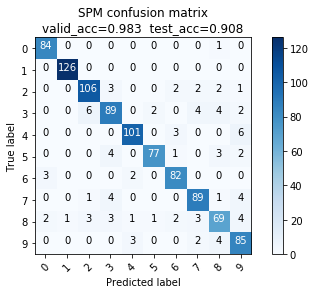

In [13]:
plot_confusion_matrix(confusion_m,classes=class_names,title='SPM confusion matrix\nvalid_acc='+str(accuracy_score(y_valid[0:1000],valid_predictions))+'  test_acc='+str(accuracy_score(y_test[0:1000],test_predictions)))